# Please UpVOTE if you like the notebook <3

HackerEarth Machine Learning challenge: How effective is the STD drug?


A new pharmaceutical startup is recently acquired by one of the world's largest MNCs. For the acquisition process, the startup is required to tabulate all drugs that they have sold and account for each drug's effectiveness. A dedicated team has been assigned the task to analyze all the data. This data has been collected over the years and it contains data points such as the drug's name, reviews by customers, popularity and use cases of the drug, and so on. Members of this team are by the noise present in the data. Your task is to make a sophisticated NLP-based Machine Learning model that has the mentioned features as the input. Also, use the input to predict the base score of a certain drug in a provided case.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/test.csv
/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/train.csv


In [2]:
# NLP
from bs4 import BeautifulSoup
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# Loading the dataset

In [166]:
df= pd.read_csv("/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/train.csv")
to_test = pd.read_csv("/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/test.csv")

In [167]:
df.describe(include='all')

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
count,32165.000000,32165,32165,32165,32165.000000,32165,32165.000000,32165.000000
unique,NaN,2220,636,30121,NaN,3537,NaN,NaN
top,NaN,Levonorgestrel,Birth Control,"""Good""",NaN,20-Jan-16,NaN,NaN
freq,NaN,724,5795,8,NaN,37,NaN,NaN
mean,115487.511052,NaN,NaN,NaN,6.998912,NaN,27.893207,6.664261
std,67146.156602,NaN,NaN,NaN,3.274781,NaN,35.819035,1.588699
min,9.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,0.899076
25%,56922.000000,NaN,NaN,NaN,5.000000,NaN,6.000000,6.109307
50%,115776.000000,NaN,NaN,NaN,8.000000,NaN,16.000000,6.788245
75%,173562.000000,NaN,NaN,NaN,10.000000,NaN,36.000000,7.900790


In [168]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


# Text Features

## Punctuations

In [6]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['review_by_patient'] = df['review_by_patient'].apply(punctuation_removal)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(punctuation_removal)

## Stopwords Removal

In [7]:
stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

df['review_by_patient'] = df['review_by_patient'].apply(stopwords_removal)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(stopwords_removal)

## Dropping numbers

In [8]:
import re

def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

df['review_by_patient'] = df['review_by_patient'].apply(drop_numbers)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(drop_numbers)

# Making a Sentiment Column

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Create list (cast to array) of compound polarity sentiment scores for reviews
train_sentiments = []
test_sentiments = []

for i in df.review_by_patient:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
for i in to_test.review_by_patient:
    test_sentiments.append(sid.polarity_scores(i).get('compound'))   
    
train_sentiments = np.asarray(train_sentiments)
test_sentiments  = np.asarray(test_sentiments)

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
df['sentiment'] = pd.Series(data=train_sentiments)
to_test['sentiment'] = pd.Series(data=test_sentiments)

Text(0, 0.5, 'Count')

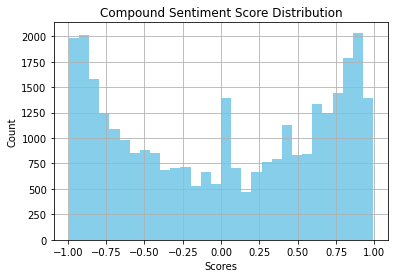

In [11]:
df.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count')

([<matplotlib.axis.XTick at 0x7f4026de6ac8>,
 <a list of 10 Text major ticklabel objects>)

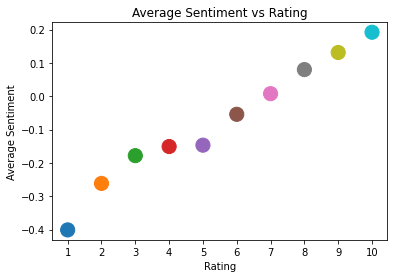

In [12]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(df[df.effectiveness_rating == i].sentiment) / np.sum(df.effectiveness_rating == i))
    

plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)])

# Most common drugs

- there are 2220 **name_of_drug** out of 32165 records

In [13]:
name_of_drug = df.name_of_drug.value_counts().sort_values(ascending=False)
name_of_drug[:10]

Levonorgestrel                        724
Etonogestrel                          628
Ethinyl estradiol / norethindrone     547
Ethinyl estradiol / norgestimate      425
Nexplanon                             397
Ethinyl estradiol / levonorgestrel    394
Phentermine                           296
Sertraline                            281
Escitalopram                          265
Mirena                                241
Name: name_of_drug, dtype: int64

# most used drug_cases

- there are 636 **use_case_for_drug** out of 32165 records

In [14]:
use_case_for_drug = df.use_case_for_drug.value_counts().sort_values(ascending=False)
use_case_for_drug[:10]

Birth Control      5795
Depression         1791
Pain               1273
Anxiety            1174
Acne               1101
Bipolar Disorde     815
Insomnia            772
Obesity             727
Weight Loss         717
ADHD                627
Name: use_case_for_drug, dtype: int64

We're familiar with these most common conditions. It makes sense that something like birth control would have more reviews than something like anthrax! (Presumably, anthrax antibiotics?)

# Effectiveness_Rating_Distribution

This distribution illustrates that people generally write reviews for drugs they really like (or those that they really dislike). There are fewer middle ratings as compared to extreme ratings.

([<matplotlib.axis.XTick at 0x7f4028795710>,
 <a list of 10 Text major ticklabel objects>)

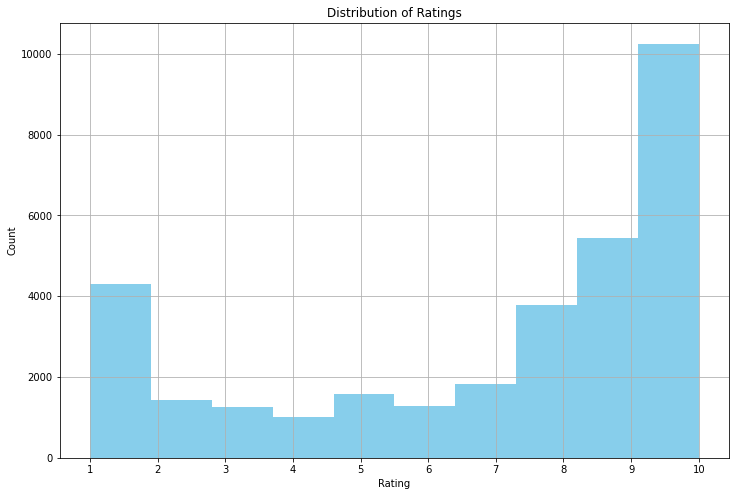

In [15]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
plt.rcParams['figure.figsize'] = [12, 8]
df.effectiveness_rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)])

In [16]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(df[df.effectiveness_rating == i].number_of_times_prescribed) / np.sum([df.effectiveness_rating == i])])
    
use_arr = np.asarray(use_ls)

([<matplotlib.axis.XTick at 0x7f4028efaac8>,
 <a list of 10 Text major ticklabel objects>)

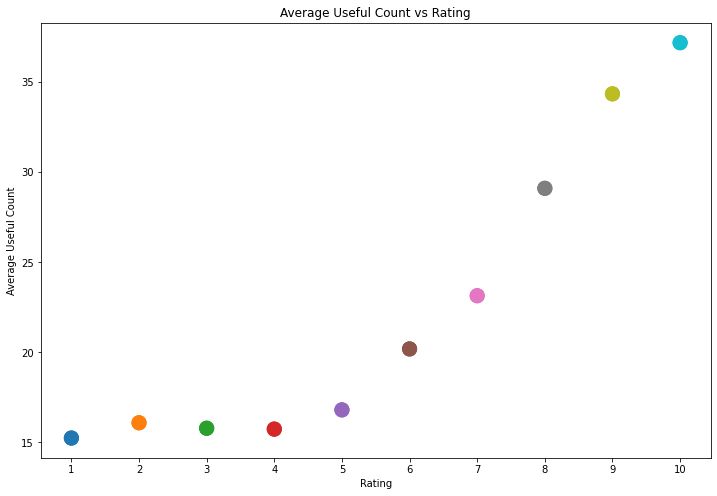

In [17]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)])

Looks like people found reviews with higher scores to be more useful! 


In the sense that reviews with high ratings recieved more 'useful' tags than reviews with low ratings.

In [19]:
# Sort train dataframe from most to least useful
df = df.sort_values(by='number_of_times_prescribed', ascending=False)
df.iloc[:10]

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,sentiment
404,62757,Citalopram,Depression,responded one week side effects lethargy bowel...,8,25-Mar-08,771,6.948738,-0.9246
31629,89689,Celexa,Depression,taking celexa months life completely different...,9,29-Jan-10,559,6.260555,-0.2729
10692,77107,Lorcaserin,Weight Loss,update one year experience belviq dropped poun...,10,21-Sep-14,556,8.755092,0.7269
23744,126310,Viibryd,Depression,atypical depression tried wellbutrin allergic ...,9,7-Sep-11,513,8.400719,-0.8578
13466,182492,Mirena,Birth Control,love mirena recommended several friends kids w...,10,1-Oct-08,505,8.412500,0.0777
28671,197749,Desvenlafaxine,Depression,trying several top ten antidepressants never f...,10,24-Jun-08,504,7.252806,0.4039
7063,138983,Phentermine,Weight Loss,lot people forum extremely unrealistic drug me...,8,18-Sep-09,476,6.494641,0.4939
16203,222844,Topamax,Obesity,topamax little less month already lost pounds ...,10,24-May-13,467,8.122917,-0.7037
22884,29632,Topiramate,Obesity,topamax little less month already lost pounds ...,10,24-May-13,467,8.122917,-0.7037
3943,151191,OxyContin,Pain,think tried every pain medication known man la...,10,12-Feb-10,463,8.024776,-0.5106


### Post Analysis i found that the Sentiment feature is not helping, also it has very less co-relation with the Target Varibale
- Largely because of the names and the conditions of the disease, for example a use_of_drug is "Depression" but that will give a negative sentiment but at the same time can have High Base_score
- Therefore dropping this column

In [169]:
df= pd.read_csv("/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/train.csv")

### Realigning the columns of test_Dataset

In [170]:
to_test = to_test[["patient_id","name_of_drug","use_case_for_drug","review_by_patient","effectiveness_rating","drug_approved_by_UIC","number_of_times_prescribed"]]
to_test.head(1)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22


# Adding a new feature -- (scaling effectiveness_rating btw 0 and 1 )

In [171]:
# ################################


min_rating = df.effectiveness_rating.min()
max_rating = df.effectiveness_rating.max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating/(max_rating -1)
    rating *= 5
    rating = int(round(rating,0))
    
    if(int(rating) == 0 or int(rating)==1 or int(rating)==2):
        return 0
    else:
        return 1
    


    
df['new_eff_score'] = df.effectiveness_rating.apply(scale_rating)
to_test['new_eff_score'] = df.effectiveness_rating.apply(scale_rating)

# X.drop("effectiveness_rating",axis=1,inplace=True)

# Adding New feature Drug Rank

In [109]:
training_conditions=df['use_case_for_drug'].unique()
testing_conditions=to_test['use_case_for_drug'].unique()

In [35]:
for i in training_conditions:
    if i not in testing_conditions:
        print(i)

Uterine Fibroids
Trichotillomania
Impetig
Oral Thrush
Prevention of Dental Caries
Bacterial Endocarditis Prevention
Hypertensive Emergency
Pulmonary Embolism, Recurrent Event
Melanoma, Metastatic
Pseudobulbar Affect
94</span> users found this comment helpful.
Deep Vein Thrombosis, First Event
28</span> users found this comment helpful.
Hemangioma
Paroxysmal Supraventricular Tachycardia
Noninfectious Colitis
75</span> users found this comment helpful.
Lewy Body Dementia
Gas
Seasonal Affective Disorde
Gouty Arthritis
Iritis
Giant Cell Tumor of Bone
13</span> users found this comment helpful.
79</span> users found this comment helpful.
Dissociative Identity Disorde
Bursitis
COPD, Acute
Influenza Prophylaxis
Dientamoeba fragilis
Lyme Disease, Neurologic
Topical Disinfection
Chronic Spasticity
Endometrial Hyperplasia
Scabies
Secondary Cutaneous Bacterial Infections
Dermatophytosis
Endoscopy or Radiology Premedication
Oophorectomy
Sore Throat
Klinefelter Syndrome
Acute Lymphoblastic Leukemia

##### since there are some conditions which are not there in training set but are in testing, therefore let's merge them.

In [36]:
big_df = pd.concat([df.drop("base_score",axis=1), to_test], ignore_index=True)

In [37]:
print(df.shape)
print(to_test.shape)
print(big_df.shape)

(32165, 9)
(10760, 8)
(42925, 8)


Let's find the highest and lowest rated drugs for each condition! This information will be helpful for a user who is looking for medication for a specific condition.

In [38]:
# Make dictionary of use_case_of_drug, each value will be a dataframe of all of the drugs used to treat the given use_case
help_dict = {}

# Iterate over conditions
for i in big_df.use_case_for_drug.unique():
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in big_df[big_df.use_case_for_drug == i].name_of_drug.unique():
        
        # If there are at least 0 reviews for a drug, save its name and average rating in temporary list
        if np.sum(big_df.name_of_drug == j) >= 0:
            temp_ls.append((j, np.sum(big_df[big_df.name_of_drug == j].effectiveness_rating) / np.sum(big_df.name_of_drug == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

Now we've got a very useful 'help_dict' dictionary!

We can simply index the dictionary by a specific condition to see the top rated drugs for that condition. For example, let's look at the top 10 drugs for birth control:

In [110]:
df.head(5)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,new_eff_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969,0
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176,1
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782,0


In [42]:
# # Top 10 drugs of Birth Control
help_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Femcon Fe,10.000000
1,Pimtrea,10.000000
2,depo-subQ provera 104,10.000000
3,Cyclessa,10.000000
4,Ortho-Novum 7 / 7 / 7,9.500000
5,Ogestrel-28,9.000000
6,Ortho-Novum 1 / 35,9.000000
7,Plan B,8.875000
8,Lybrel,8.333333
9,Ethinyl estradiol / folic acid / levonorgestrel,8.000000


In [44]:
count = 0
def rank_drug_test(name):
    global count 
    use_case = to_test.iloc[count][2]
    count = count + 1
#     print(use_case)
    a = help_dict[use_case]   ## this will create a dataframe
    rank=a.index[a['drug'] == name].tolist()
    
    if(rank[0] > 30 ):                                  ## those who has less than 30 reviews are ranked zero
        return 0
    else:
        return (30-rank[0])                             ## The topn review will  get 30 as rank ( higher the better)
    
    
    
def rank_drug_train(name):
    global count 
    use_case = df.iloc[count][2]
    count = count + 1
#     print(use_case)
    a = help_dict[use_case]   ## this will create a dataframe
    rank=a.index[a['drug'] == name].tolist()
    
    if(rank[0] > 30 ):                                  ## those who has less than 30 reviews are ranked zero
        return 0
    else:
        return (30-rank[0])       

### high Rank = Good Average score!

In [45]:
df['rank_of_drug'] = df['name_of_drug'].apply(rank_drug_train)
count =0
to_test['rank_of_drug'] = to_test['name_of_drug'].apply(rank_drug_test)


In [112]:
to_test.head(3)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating,new_eff_score
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10,1
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9,1
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4,0


In [113]:
df.head(3)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,new_eff_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969,0


#### dropping ranks .. as they were not giving good results

# Dropping the unnecessary features

In [114]:

df.drop(["patient_id","name_of_drug",
        "use_case_for_drug",
        "review_by_patient","drug_approved_by_UIC","rank_of_drug"],axis=1,inplace=True)


to_test.drop(["patient_id","name_of_drug",
        "use_case_for_drug",
        "review_by_patient","drug_approved_by_UIC","rank_of_drug"],axis=1,inplace=True)

In [173]:
df.head(3)

,effectiveness_rating,number_of_times_prescribed,base_score,new_eff_score
0,9,27,8.022969,1
1,8,192,7.858458,1
2,5,17,6.341969,0


In [174]:
to_test.head(3)

,effectiveness_rating,number_of_times_prescribed,new_eff_score
0,10,22,1
1,9,35,1
2,4,13,0


# Plotting the correlatiion

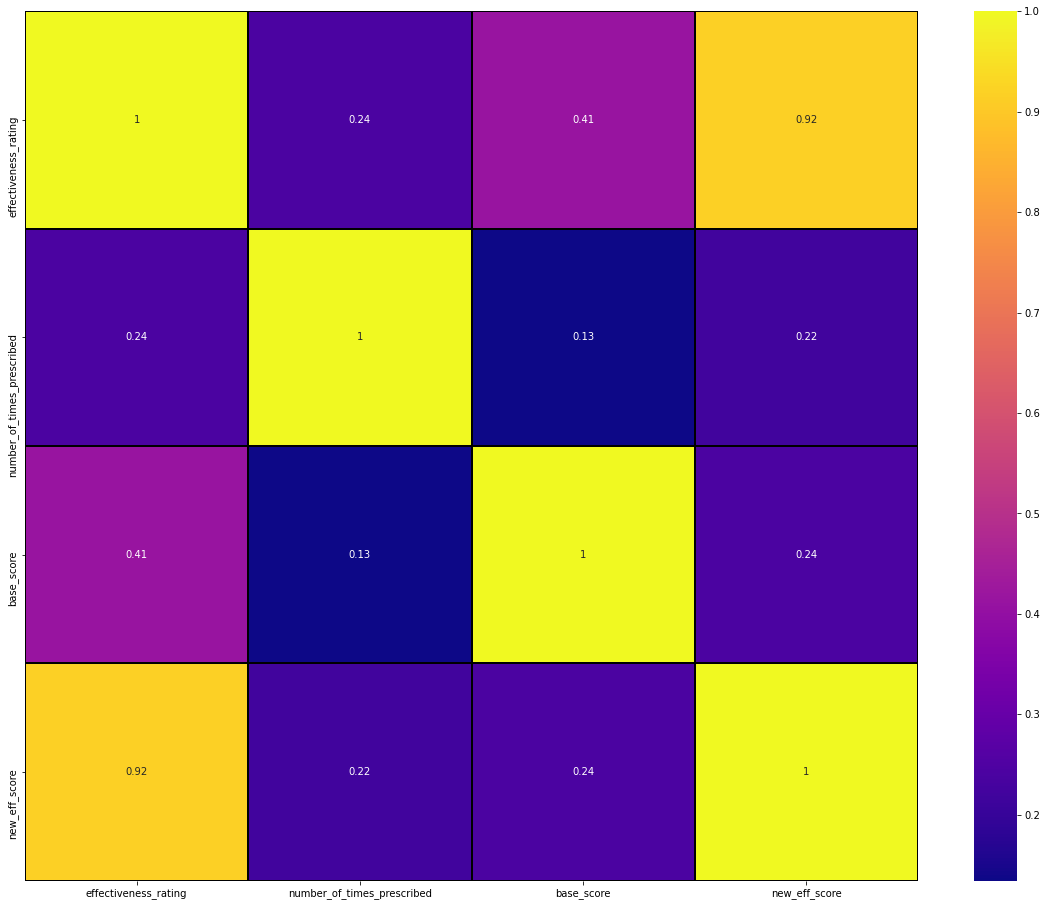

In [175]:
tc = df.corr() 

plt.figure(figsize=(20,16))
sns.heatmap(tc, annot = True, cmap ='plasma',  
            linecolor ='black', linewidths = 1) 


# Scaling

In [176]:
X = df.drop("base_score",axis=1)
y= df.base_score

from sklearn.preprocessing import  MinMaxScaler
sc= MinMaxScaler()
X= sc.fit_transform(X)
y= y.values.reshape(-1,1)


to_test = sc.transform(to_test)

In [177]:
################################

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

# X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

# Spliting into X and Y ( 30% testing - 70 training )

In [178]:
################################

from sklearn.model_selection import train_test_split as split

X_train, X_test, y_train, y_test = split(X,y, test_size=0.01,random_state=51)#

In [179]:
X_train

array([[0.44444444, 0.00389105, 0.        ],
       [0.33333333, 0.00648508, 0.        ],
       [0.88888889, 0.02464332, 1.        ],
       ...,
       [1.        , 0.04798962, 1.        ],
       [0.88888889, 0.0155642 , 1.        ],
       [0.44444444, 0.01815824, 0.        ]])

In [180]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31843, 3)
(31843, 1)
(322, 3)
(322, 1)


# Model

In [181]:
# import lightgbm as lgb


# Using HyperOpt to find best parameters for XGBOOST and LGBM

### Hyperopt
Hyperopt is a python library for search spaces optimizing. Currently it offers two algorithms for minimizing the cost function,
- 1. Random Search  
- 2. Tree of Parzen Estimators (TPE) 

which is a Bayesian approach which makes use of P(x|y) instead of P(y|x), based on approximating two different distributions separated by a threshold instead of one in calculating the Expected Improvement 

In [182]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

- hp.choice(label, options): index of an option
- hp.uniform(label, low, high) : uniform value between low/high

In [183]:
# XGB parameters
xgb_reg_params = {
#     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.15, 0.25, 0.01)),
    'n_estimators':     hp.choice('n_estimators', np.arange(1000,1800,10, dtype=int)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 15, 1, dtype=int)),
#     'gamma': hp.choice('gamma', np.arange(0, 0.4, 0.1, dtype=int)),
#     'subsample':        hp.uniform('subsample', 0.8, 1),
}


xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}


from sklearn.metrics import mean_squared_error
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y,pred: np.sqrt(mean_squared_error(y, pred))

In [184]:
# # LightGBM parameters

# # reg_params for object instantiation
# lgb_reg_params = {
#     'learning_rate':    hp.choice('learning_rate',    np.arange(0.1, 0.5, 0.05)),
#     'max_depth':        hp.choice('max_depth',        np.arange(5, 20, 1, dtype=int)),
#     'num_leaves': hp.choice('num_leaves', np.arange(16, 40, 2, dtype=int)),
# #     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
# #     'num_leaves':        hp.choice('num_leaves', 200, 400,5, dtype=int),
#     'n_estimators':     hp.choice('n_estimators', np.arange(1500,2100,10, dtype=int)),
#     'random_state': 51,
#     'boosting_type': 'gbdt'
# }


# # fit_params for the fit() function
# lgb_fit_params = {
#     'eval_metric': 'rmse',
#     'early_stopping_rounds': 10,
#     'verbose': False
# }


# lgb_para = dict()
# lgb_para['reg_params'] = lgb_reg_params
# lgb_para['fit_params'] = lgb_fit_params
# lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

After setting the parameters we can create a class HPOpt that is instantiated with training and testing data and provides the training functions. Here I include only the Regressor examples. You may add your own classification, training or cross-validation function inside the class.

In [185]:
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [186]:
class HPOpt(object):
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train#.ravel()
        self.y_test  = y_test#.ravel()

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


Given the pre-defined DataFrames x_train, x_test, y_train, y_test , we can run the optimization process by calling process() :

In [187]:
obj = HPOpt(X_train, X_test, y_train, y_test)

# For XGBOOST

### Search Algortihm: 
- either hyperopt.tpe.suggest 
- or
- hyperopt.rand.suggest

In [70]:
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [07:47<00:00,  4.67s/trial, best loss: 0.061748855811563884]


In [71]:
print (xgb_opt)

({'learning_rate': 8, 'max_depth': 0, 'n_estimators': 0}, <hyperopt.base.Trials object at 0x7f402785a6a0>)


#### always count from 0, i.e here learning_rate : 1 means that in parameter np.arrange(0.1,0.35,0.05) = [0.1,0.15,0.20,0.25,...]  we have to choose the second element i.e 0.15 in this case.

# Applying the optimised parameters to XGBOOST

### you can tune the parameters acc to your choice in xgb_reg_params {}

In [188]:
model = xgb.XGBRegressor( #colsample_bytree = 0.7,
                         learning_rate=0.17,
                         n_estimators =1400,
                         max_depth =5,
#                          min_child_weight=0,
#                          subsample=0.895795844955654,
#                          gamma=0.1,
    
                        )
model.fit(X_train, y_train)#.ravel()
y_pred = model.predict(X_test)


from sklearn import metrics

print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

0.08425582483607123


In [189]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)   # best = 1

0.9971221262314651

# For LGBM

In [190]:
# lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [191]:
# print (lgb_opt)

In [192]:
# 0.9996468659750317

# Applying the optimised parameters to LGBM

In [193]:
# l_obj = lgb.LGBMRegressor(boosting_type='gbdt',
#                             num_leaves=30,
#                             max_depth=13,
#                             learning_rate=0.35,
#                             n_estimators=2100,
#                             random_state=51,
#                             n_jobs=-1,
# #                             silent=-1,
#                          )

# l_obj.fit(X_train, y_train.ravel())
# y_pred = l_obj.predict(X_test)


# print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

###### Checking R-Square Error

In [194]:
# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred)   # best = 1

# Applying Stacking Regressor

In [195]:
# base_learners = [
#                  ('rf_1', xgb.XGBRegressor( n_estimators =1160,
#                          colsample_bytree = 0.7,
#                          learning_rate=0.2,
#                          max_depth =7,
#                          min_child_weight=0,
#                          subsample=0.8380905249423865,
# #                          gamma=0,
    
#                         )),
    
    
#                        ('bharat', lgb.LGBMRegressor(boosting_type='gbdt',
#                             num_leaves=30,
#                             max_depth=13,
#                             learning_rate=0.35,
#                             n_estimators=2100,
#                             random_state=51,
#                             n_jobs=-1,
# #                             silent=-1,
#                          ))    
#                 ]

In [196]:
# from sklearn.ensemble import StackingRegressor

In [197]:
# from sklearn.ensemble import RandomForestRegressor
# reg = StackingRegressor(estimators=base_learners, 
#                          final_estimator=RandomForestRegressor(n_estimators=10,
#                                            random_state=42)
#                         )

In [198]:
# reg.fit(X_train, y_train.ravel())
# y_pred = reg.predict(X_test)


# print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

In [199]:
# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred)   # best = 1

# Submission

# Saving

In [200]:
to_test

array([[1.        , 0.02853437, 1.        ],
       [0.88888889, 0.04539559, 1.        ],
       [0.33333333, 0.01686122, 0.        ],
       ...,
       [1.        , 0.05577173, 1.        ],
       [0.77777778, 0.00907912, 1.        ],
       [0.88888889, 0.05966278, 0.        ]])

### -IMPORTANT NOTE: you should train the model on whole given training dataset set and then run the below part

In [201]:
# model = xgb.XGBRegressor( #colsample_bytree = 0.7,
#                          learning_rate=0.17,
#                          n_estimators =1400,
#                          max_depth =5,
# #                          min_child_weight=0,
# #                          subsample=0.895795844955654,
# #                          gamma=0.1,
    
#                         )
# model.fit(X_train, y_train)#.ravel()
# y_pred = model.predict(X_test)


# from sklearn import metrics

# print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

In [202]:
result = model.predict(to_test)

In [203]:
result.max()

9.028622

In [204]:
result.min()

0.899259

In [205]:
result.mean()

6.675216

In [206]:
temp_df=pd.read_csv("/kaggle/input/hackerearth-effectiveness-of-std-drugs/dataset/test.csv")

result_data=temp_df['patient_id']

result_data = pd.DataFrame(result_data)

result_data['base_score']=result

result_data.to_csv('std_95.csv',index=False) 

result_data.head()

,patient_id,base_score
0,163740,8.757320
1,39293,8.746252
2,208087,5.953680
3,23295,5.983155
4,97013,5.361367


# End - Please Upvote